# MLflow Example Notebook

---

This notebook demonstrates an example of dataset preprocessing, ML model training and evaluation, model tuning via MLflow tracking and finally REST API model serving via MLflow models.


- **Dateset:** Bike Sharing Dataset: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- **Goal:** predict `cnt` (count per hour) based on weather and time information.


**References:**
- https://docs.databricks.com/_static/notebooks/gbt-regression.html
- https://www.kaggle.com/pratsiuk/mlflow-experiment-automation-top-9
- https://mlflow.org/docs/latest/tracking.html

# Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from IPython import get_ipython

plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

# Import Data

Dataset and explanation:
http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

- Input file: `hour.csv` - contains bike sharing counts aggregated on hourly basis. 
- Size: 17379 hours / rows


In [3]:

import requests
import zipfile
import io
content = requests.get("https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip", verify=False).content
with zipfile.ZipFile(io.BytesIO(content)) as arc:
    df = pd.read_csv(arc.open("hour.csv"), header=0, sep=',', parse_dates=['dteday']) 

In [4]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


### **Attributes Information**
 
### Deskripsi Kolom

| Nama Kolom | Deskripsi | Tipe Data |
|---|---|---|
| `instant` | ID unik untuk setiap baris data | `int64` |
| `date` | Tanggal | `datetime64[ns]` |
| `season` | Musim (1: Spring, 2: Summer, 3: Fall, 4: Winter) | `int64` |
| `weather` | Cuaca (1: Clear, 2: Cloudy, 3: Rainy, 4: Snowy) | `int64` |
| `temp` | Temperatur (Celsius) | `float64` |
| `atemp` | Temperatur yang terasa (Celsius) | `float64` |
| `humidity` | Kelembapan (%) | `float64` |
| `windspeed` | Kecepatan angin (km/jam) | `float64` |
| `casual` | Jumlah pengguna kasual | `int64` |
| `registered` | Jumlah pengguna terdaftar | `int64` |
| `count` | Jumlah total penggunaan sepeda | `int64` |
| `weekday` | Hari dalam seminggu (0: Sunday, 1: Monday, ..., 6: Saturday) | `int64` |
| `workingday` | Hari kerja (0: No, 1: Yes) | `int64` |
| `holiday` | Hari libur (0: No, 1: Yes) | `int64` |
| `yr` | Tahun | `int64` |
| `mnth` | Bulan (1: January, 2: February, ..., 12: December) | `int64` |
| `hum` | Kelembapan (%) | `float64` |

### Catatan

- Kolom `instant` tidak memiliki makna intrinsik dan hanya digunakan untuk identifikasi.
- Kolom `date` direpresentasikan dalam format `datetime64[ns]`, yang menunjukkan tanggal dan waktu dengan presisi nanosecond.
- Kolom `season`, `weather`, `weekday`, `workingday`, `holiday`, `yr`, dan `mnth` bersifat kategorikal.
- Kolom `temp`, `atemp`, `humidity`, `windspeed`, `casual`, `registered`, `count`, dan `hum` bersifat numerik.

### Referensi

- [UCI Machine Learning Repository: Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)




## Data preprocessing

In [5]:
# remove unused columns
df.drop(columns=["instant", "dteday", "registered", "casual"], inplace=True)

kolom kolom tersebut dihapus karena :
- `instant` : kolom ini berisi nilai yg unique (semacam ID)
- `dteday` : kolom ini sudah diwakilkan dengan kolom `yr`, `mnth`, `hr`, `holiday`, `workingday`
- `registered` & `casual` : kolom ini dihapus karena kolom `cnt` merupakan gabungan dari kedua kolom tersebut, sehingga kolom `cnt` sudah mewakilkan kedua kolom tersebut

In [6]:
# info dari dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


### Menampilkan gambaran informasi dari setiap Kolom

In [7]:
df_description = []

for i in df.columns:
    df_description.append([i,df[i].dtypes,
                    df[i].isna().sum(),
                    round((df[i].isna().sum()/len(df)*100),2),
                    df[i].nunique(),
                    df[i].sample(3).values])

df_info = pd.DataFrame(df_description, columns = ['kolom', 'tipe data', 'null', 'null_persentase', 'jumlah_unik','sample_unik'])
df_info

,kolom,tipe data,null,null_persentase,jumlah_unik,sample_unik
0,season,int64,0,0.0,4,"[1, 1, 2]"
1,yr,int64,0,0.0,2,"[0, 1, 0]"
2,mnth,int64,0,0.0,12,"[11, 8, 5]"
3,hr,int64,0,0.0,24,"[11, 10, 13]"
4,holiday,int64,0,0.0,2,"[0, 0, 0]"
5,weekday,int64,0,0.0,7,"[0, 4, 0]"
6,workingday,int64,0,0.0,2,"[1, 1, 1]"
7,weathersit,int64,0,0.0,4,"[1, 1, 1]"
8,temp,float64,0,0.0,50,"[0.24, 0.32, 0.6]"
9,atemp,float64,0,0.0,65,"[0.3939, 0.2879, 0.5]"


In [8]:
df.duplicated().sum()

2

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.isna().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

### korelasi antar kolom numerik

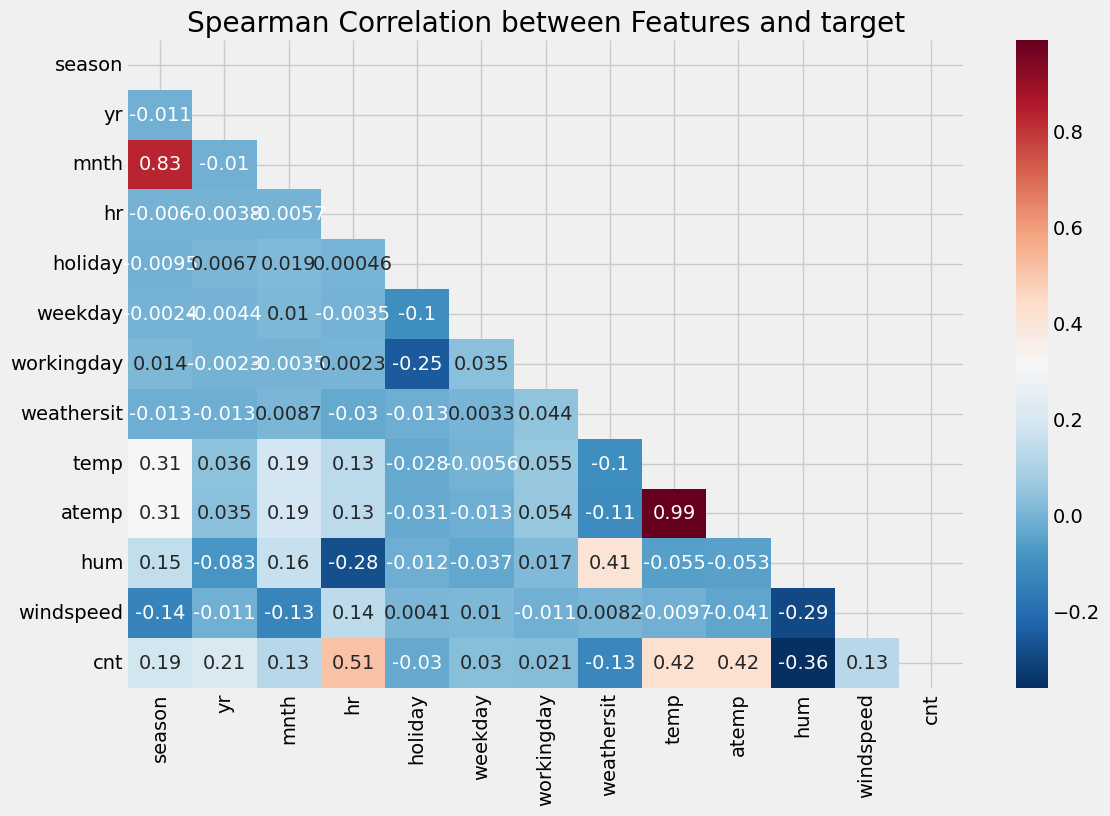

In [12]:
# Mengambil hanya kolom-kolom numerik dari DataFrame df
# Filter only numerical columns
df_numeric = df.select_dtypes(include=['number'])

# Menghitung korelasi Spearman
corr_spearman = df_numeric.corr(method='spearman')

# Mengubah elemen-elemen di bawah diagonal utama menjadi NaN
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))

# Membuat Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_spearman, cmap="RdBu_r", annot=True, mask=mask)

plt.title('Spearman Correlation between Features and target')
plt.show()

## Menghapus Outlier

dilakukan penanganan outlier agar tidak mengganggu hasil prediksi dan modeling. Tetapi, penghapusan outlier dipertimbangkan oleh kebutuhan bisnis jika terdapat suatu outlier pada sebuah kolom tetapi masih sesuai dengan bisnis maka tidak akan kita hapus.

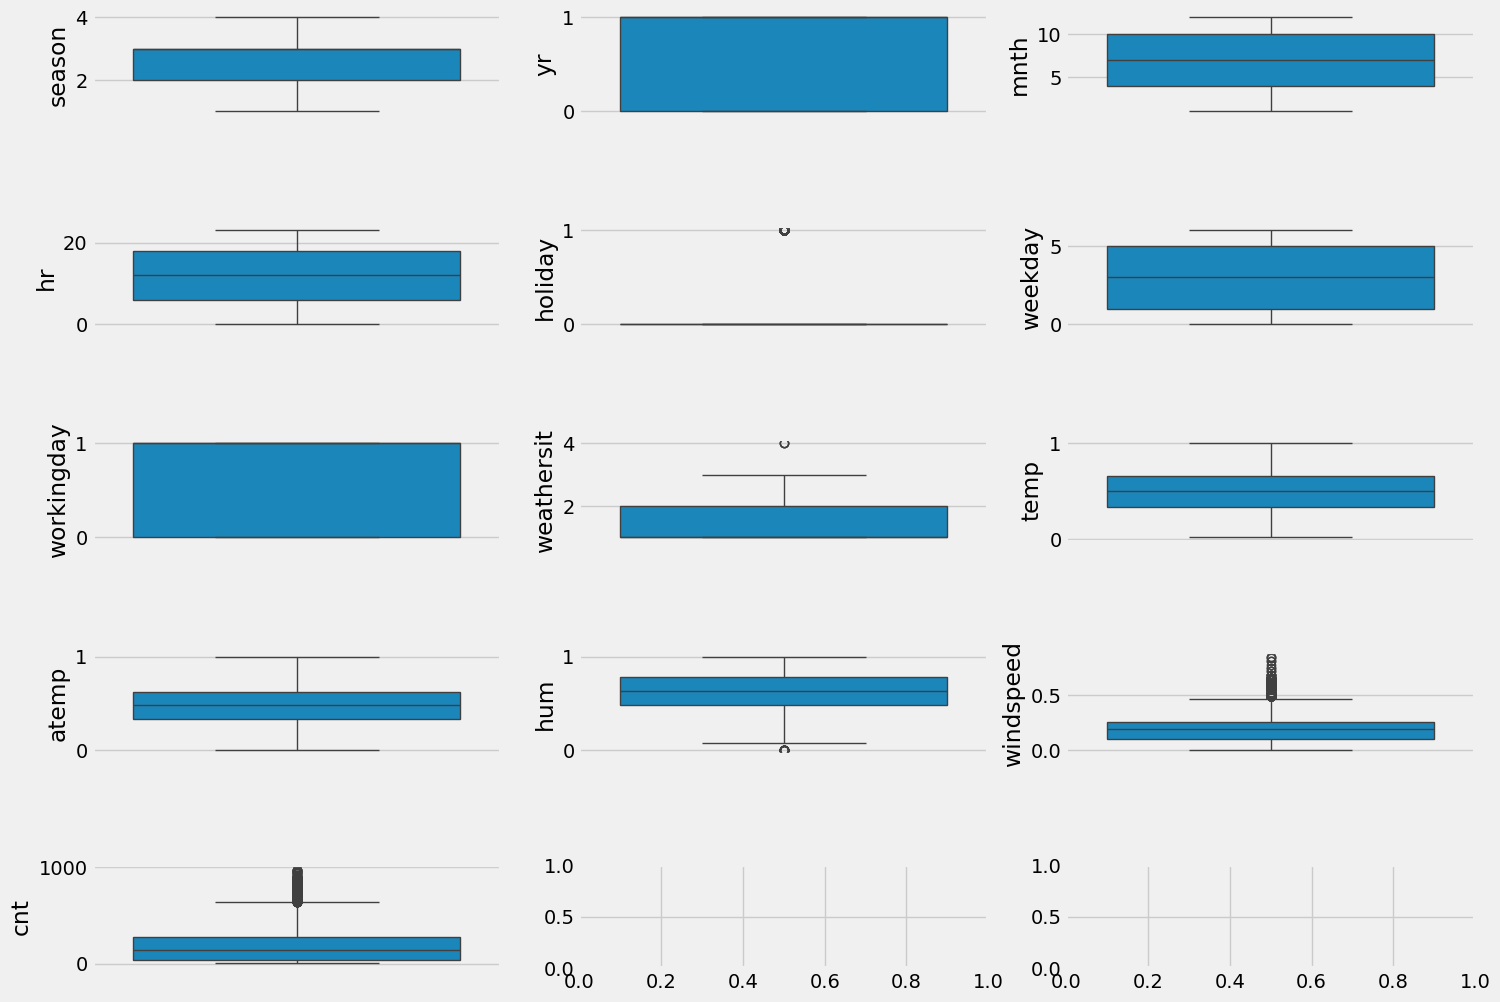

In [13]:
# Check Outliers kolom numerik
df_numerik = df.select_dtypes(include=[float, int]).columns

fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(15,10))
index = 0
ax = ax.flatten()

for kolom in df_numerik:
    sns.boxplot(y=kolom, data=df, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

plt.show()

In [14]:
def remove_outliers(df, column):
    while True:
        # Hitung Q1 dan Q3
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        # Hitung IQR
        IQR = Q3 - Q1

        # Tentukan batas bawah dan atas untuk mengidentifikasi outlier
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Hapus outlier dari dataset
        df_outliers_removed = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

        # Cek apakah masih ada outlier
        if len(df_outliers_removed) == len(df):
            break  # Jika tidak ada outlier lagi, keluar dari loop
        else:
            df = df_outliers_removed  # Jika masih ada outlier, lanjutkan iterasi

    return df_outliers_removed

### Outlier kolom `cnt`

In [15]:
df = remove_outliers(df, 'cnt')

### Outlier kolom `windspeed`

In [16]:
df = remove_outliers(df, 'windspeed')


### Outlier kolom `weathersit`

In [17]:
df['weathersit'].value_counts()

weathersit
1    10633
2     4359
3     1352
4        3
Name: count, dtype: int64

Karena jumlah data cuaca (4) = 3 (badai) datanya sangat sedikit dan jika outlier tidak dihilangkan maka model machine learning tidak terlalu mempelajari data tersebut. Sehingga kita dapat menghapus outlier tersebut

In [18]:
df = remove_outliers(df, 'weathersit')


In [19]:
df['weathersit'].value_counts()

weathersit
1    10633
2     4359
3     1352
Name: count, dtype: int64

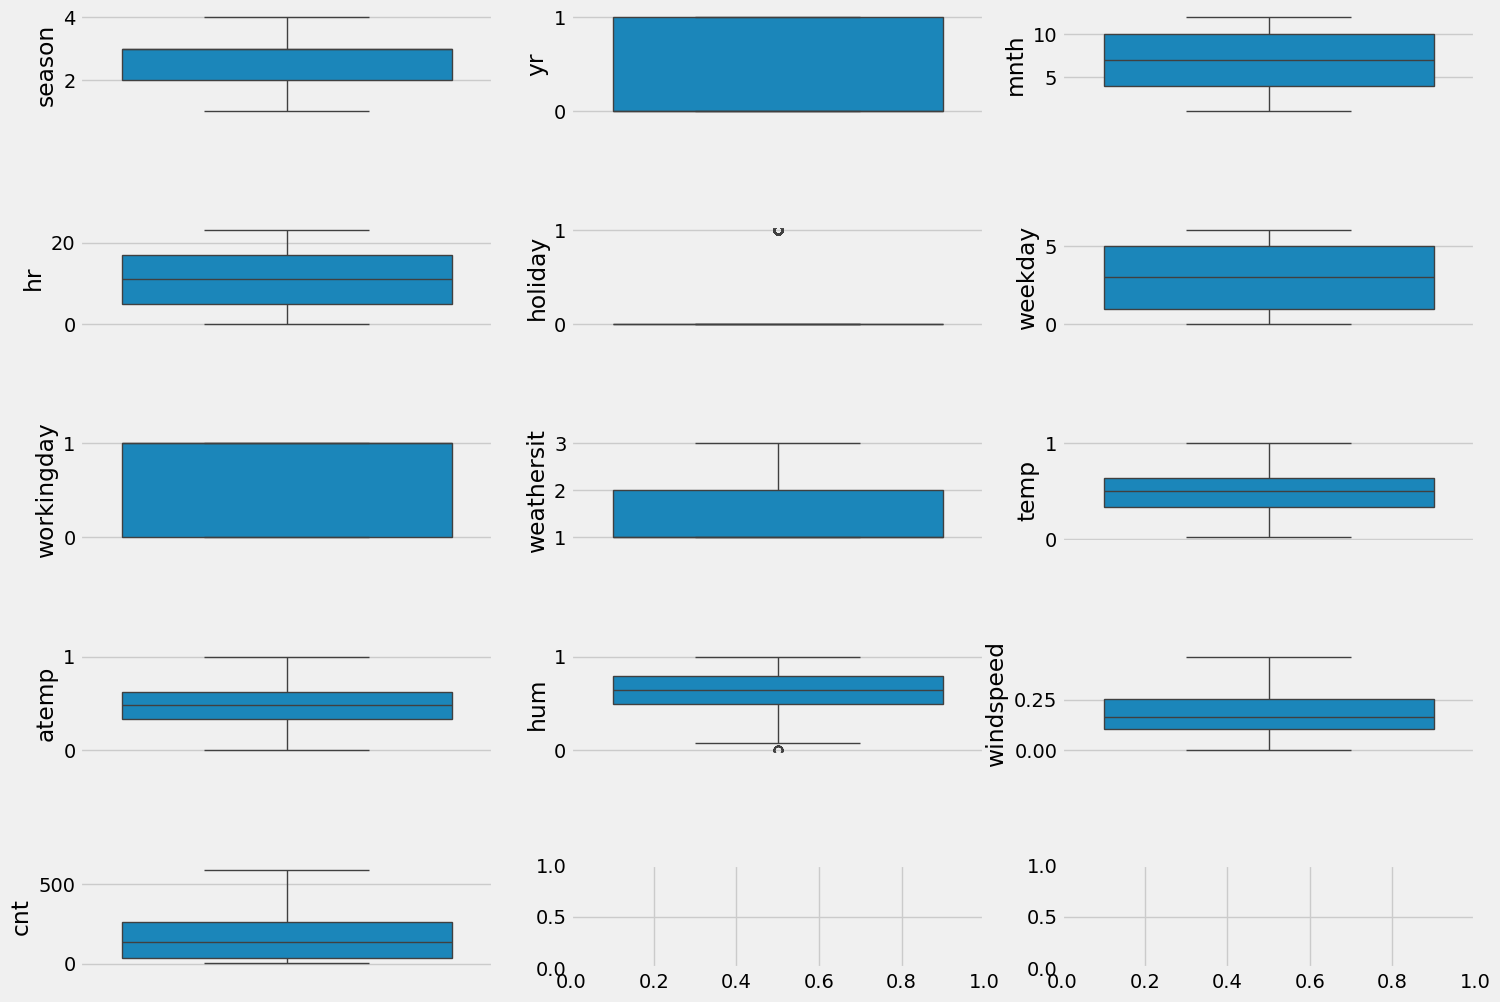

In [20]:
# Check Outliers kolom numerik
df_numerik = df.select_dtypes(include=[float, int]).columns

fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(15,10))
index = 0
ax = ax.flatten()

for kolom in df_numerik:
    sns.boxplot(y=kolom, data=df, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

plt.show()

In [21]:
df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61


### Data Visualization 

#### Total jumlah sepeda yang direntalkan per jam dalam sehari

<Axes: title={'center': 'Total rented bikes by hour of day'}, xlabel='hr'>

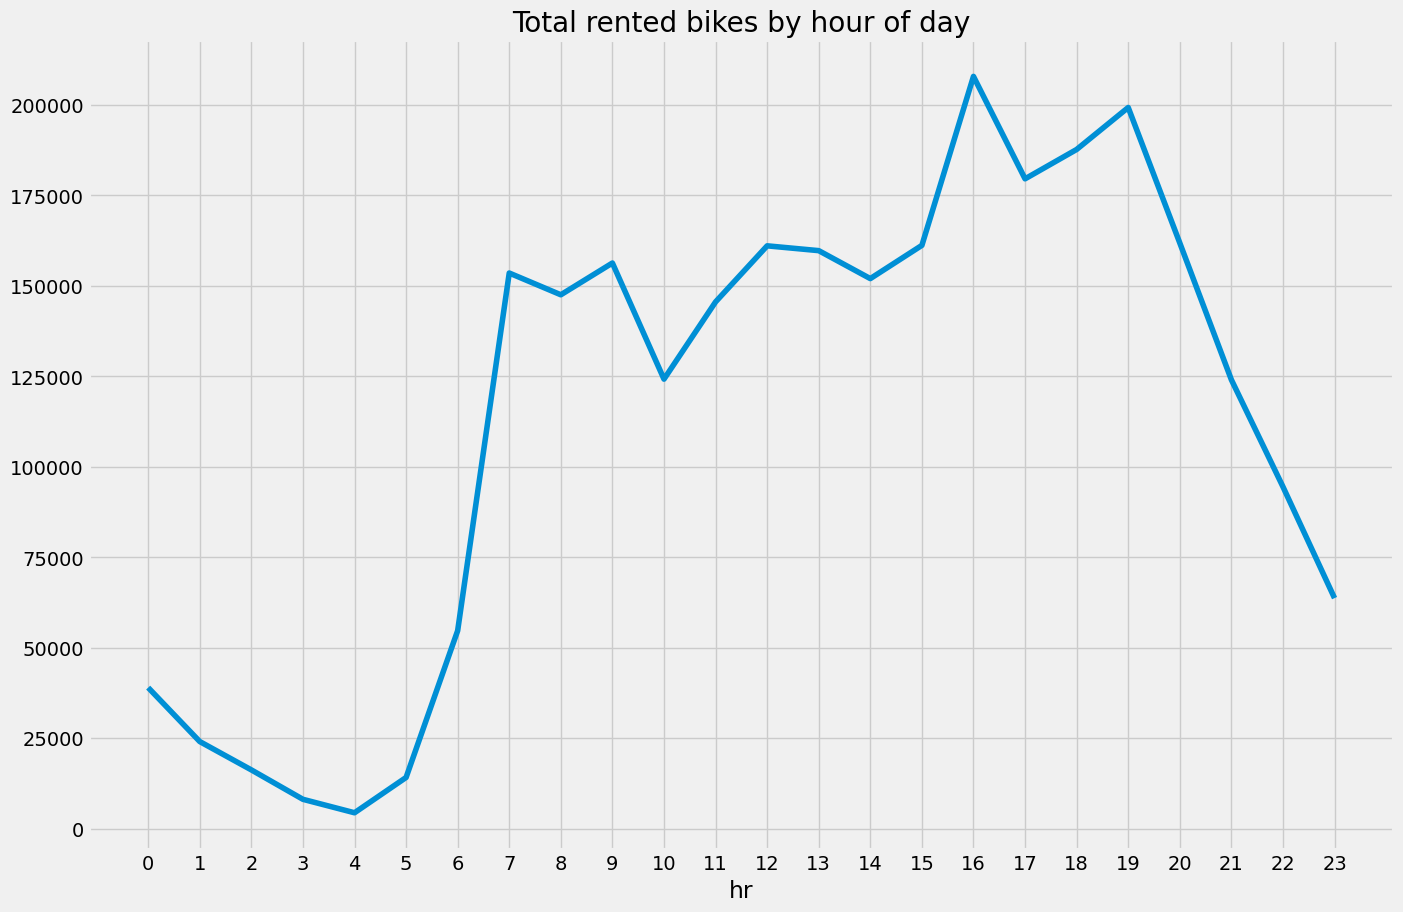

In [22]:
hr_agg = df.groupby(["hr"])["cnt"].sum()

hr_agg.plot(
    kind="line", 
    title="Total rented bikes by hour of day",
    xticks=hr_agg.index,
    figsize=(15, 10),
)

## Prepare training and test data sets


In [23]:
# Split the dataset randomly into 70% for training and 30% for testing.
X = df.drop("cnt", axis=1)
y = df.cnt
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.size}")
print(f"Test samples: {X_test.size}")

Training samples: 156900
Test samples: 39228


# Evaluation Metrics

on cross-validation step, we'll use RMSE metric

We will use RMSE, MAE, MAPE on hyperparameter tuning


## Feature Importance

Background: https://medium.com/bigdatarepublic/feature-importance-whats-in-a-name-79532e59eea3

In [24]:
def model_feature_importance(model):
    feature_importance = pd.DataFrame(
        model.feature_importances_,
        index=X_train.columns,
        columns=["Importance"],
    )

    # sort by importance
    feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=feature_importance.reset_index(),
        y="index",
        x="Importance",
    ).set_title("Feature Importance")
    # save image
    plt.savefig("model_artifacts/feature_importance.png", bbox_inches='tight')

## Permutation Importance

Background: https://www.kaggle.com/dansbecker/permutation-importance

In [25]:
def model_permutation_importance(model):
    p_importance = permutation_importance(model, X_test, y_test, random_state=42, n_jobs=-1)

    # sort by importance
    sorted_idx = p_importance.importances_mean.argsort()[::-1]
    p_importance = pd.DataFrame(
        data=p_importance.importances[sorted_idx].T,
        columns=X_train.columns[sorted_idx]
    )

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=p_importance,
        orient="h"
    ).set_title("Permutation Importance")

    # save image
    plt.savefig("model_artifacts/permutation_importance.png", bbox_inches="tight")

# MLflow Tracking

Reference: https://www.mlflow.org/docs/latest/cli.html#mlflow-ui


## Start experiments tracking UI

In [26]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 3000 &")

# Model Training


## Model Type & Method


"Linear Regression", "Random Forest", "Support Vector Regressor", "Gradient Boosting Regressor"

For this example, we will use best model from cross-validation.

Background:
- Choosing a model: https://scikit-learn.org/stable/tutorial/machine_learning_map
- Machine Learning Models Explained
: https://docs.paperspace.com/machine-learning/wiki/machine-learning-models-explained


## Cross-Validation

In [27]:

from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

In [28]:
from datetime import datetime
# Fungsi untuk melakukan cross-validation dan mendapatkan model terbaik
def find_best_model(X, y):
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(),
        "Support Vector Regressor": SVR(),
        "Gradient Boosting Regressor" : GradientBoostingRegressor(),
    }

    best_model = None
    best_model_name = None
    best_rmse = float('inf')

    for name, model in models.items():
        # Cross-validation menggunakan KFold
        kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X_train.values)
        rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

        # Hitung RMSE pada setiap fold
        rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)

        # Hitung rata-rata RMSE dari cross-validation
        avg_rmse = np.mean(rmse_scores)

        date = datetime.now().strftime("%d/%m/%Y")
        experiment_name = 'Tracking cross-validation'
        experiment_name = experiment_name + ' - ' + date
        dt = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        run_name = name + " - " + dt
        
        print('Run_Name: ',run_name)
        
        mlflow.set_experiment(experiment_name)
        mlflow.set_tracking_uri("./mlruns")
        with mlflow.start_run(run_name=run_name):
            mlflow.log_metric("AVG RMSE", avg_rmse) 
            mlflow.set_tag("estimator_name", name)

            # log input features
            mlflow.set_tag("features", str(X_train.columns.values.tolist()))
            # mlflow.sklearn.log_model(model,name)
        # Update model terbaik jika ditemukan skor RMSE lebih baik
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_model = model
            best_model_name = name

        print(f"{name} - Avg RMSE: {avg_rmse}")
        print("-------------------------------------------------------")

    print("best_model_name : ",best_model_name)
    mlflow.sklearn.log_model(best_model,best_model_name)
    return best_model


In [29]:
mlflow.end_run()

In [30]:
# Log model terbaik ke dalam MLflow
best_model = find_best_model(X_train, y_train)

Run_Name:  Linear Regression - 21/02/2024 14:04:15
Linear Regression - Avg RMSE: 115.52064086514933
-------------------------------------------------------


[2024-02-21 14:04:16 +0700] [44445] [INFO] Starting gunicorn 21.2.0
[2024-02-21 14:04:16 +0700] [44445] [INFO] Listening at: http://127.0.0.1:3000 (44445)
[2024-02-21 14:04:16 +0700] [44445] [INFO] Using worker: sync
[2024-02-21 14:04:16 +0700] [44446] [INFO] Booting worker with pid: 44446
[2024-02-21 14:04:16 +0700] [44447] [INFO] Booting worker with pid: 44447
[2024-02-21 14:04:16 +0700] [44448] [INFO] Booting worker with pid: 44448
[2024-02-21 14:04:16 +0700] [44455] [INFO] Booting worker with pid: 44455


Run_Name:  Random Forest - 21/02/2024 14:04:28
Random Forest - Avg RMSE: 40.254410295839754
-------------------------------------------------------
Run_Name:  Support Vector Regressor - 21/02/2024 14:04:42
Support Vector Regressor - Avg RMSE: 112.40584179349825
-------------------------------------------------------
Run_Name:  Gradient Boosting Regressor - 21/02/2024 14:04:45
Gradient Boosting Regressor - Avg RMSE: 64.03652506121671
-------------------------------------------------------
best_model_name :  Random Forest


In [31]:
print(best_model)

RandomForestRegressor()


In [32]:
# get best model
model_class = best_model

## Model Hyper-parameters 


### Tuning the hyper-parameters: Grid search

- Simple but inefficient
- more advanced tuning techniques: https://research.fb.com/efficient-tuning-of-online-systems-using-bayesian-optimization/

In [33]:
hyperparameters = {
    'model__n_estimators': [100,200,300], 
    'model__max_features': [6,8,10,12,14,16], 
    # "verbose": True,
}

## Training runs

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlflow.models.signature import infer_signature

In [36]:
tuned_model = None

# Fungsi untuk membuat feature names
def generate_feature_names(X):
    return [f'feature_{i}' for i in range(X.shape[1])]

# Fungsi untuk melakukan training model dan logging evaluation metric
def train_and_log_metrics(X_train, y_train, X_test, y_test):
    

    date = datetime.now().strftime("%d/%m/%Y")
    experiment_name = 'Tracking Hyperparameters Tuning'
    experiment_name = experiment_name + ' - ' + date
    dt = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    run_name = model_class.__class__.__name__ + " - " + dt
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri("./mlruns")
    
    with mlflow.start_run(run_name=run_name):
        # Inisialisasi model (ganti dengan model Anda)
        pipeline = Pipeline([
            ('model', model_class)
        ])

        kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X_train.values)

        # Inisialisasi GridSearchCV jika ingin melakukan tuning parameter
        grid_search = GridSearchCV(pipeline, param_grid=hyperparameters, cv=kf)

        # Training model
        grid_search.fit(X_train, y_train)

        tuned_model = grid_search.best_estimator_

        # Prediksi menggunakan data test
        y_pred = tuned_model.predict(X_test)

        # Menghitung evaluation metric (misalnya, RMSE, MAE, dan MAPE)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        # Logging evaluation metric
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mape", mape)

        # Logging feature importances
        if isinstance(tuned_model['model'], RandomForestRegressor):
            # generate charts
            model_feature_importance(tuned_model['model'])
            # Log the figure
            mlflow.log_figure(plt.gcf(), "feature_importance_plot.png")
            model_permutation_importance(tuned_model['model'])
            # Log the figure
            mlflow.log_figure(plt.gcf(), "permutation_importance.png")
        else:
            print("Model tidak mendukung feature_importances_")

        # Logging residual plot
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=np.mean(residuals), color='r', linestyle='--', label='Mean Residual')  # Tambahkan garis tengah
        plt.title('Residual Plot')
        plt.xlabel('Predictions')
        plt.ylabel('Residuals')
        plt.legend()
        mlflow.log_figure(plt.gcf(), "residual_plot.png")

        # Logging actual vs prediction plot
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k')
        plt.title('Actual vs Prediction Plot')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        mlflow.log_figure(plt.gcf(), "actual_vs_prediction_plot.png")

        # Log tracked parameters only
        best_params = {key.split("__")[1]: value for key, value in dict(grid_search.best_params_).items()}
        print("best_params : ", best_params)
        mlflow.log_params(best_params)
        # Log model
        mlflow.sklearn.log_model(tuned_model['model'], 
                                 "model", 
                                 registered_model_name=model_class.__class__.__name__, 
                                 signature=infer_signature(X_train, y_train))

In [37]:
mlflow.end_run()

best_params :  {'max_features': 10, 'n_estimators': 200}


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '3' of model 'RandomForestRegressor'.


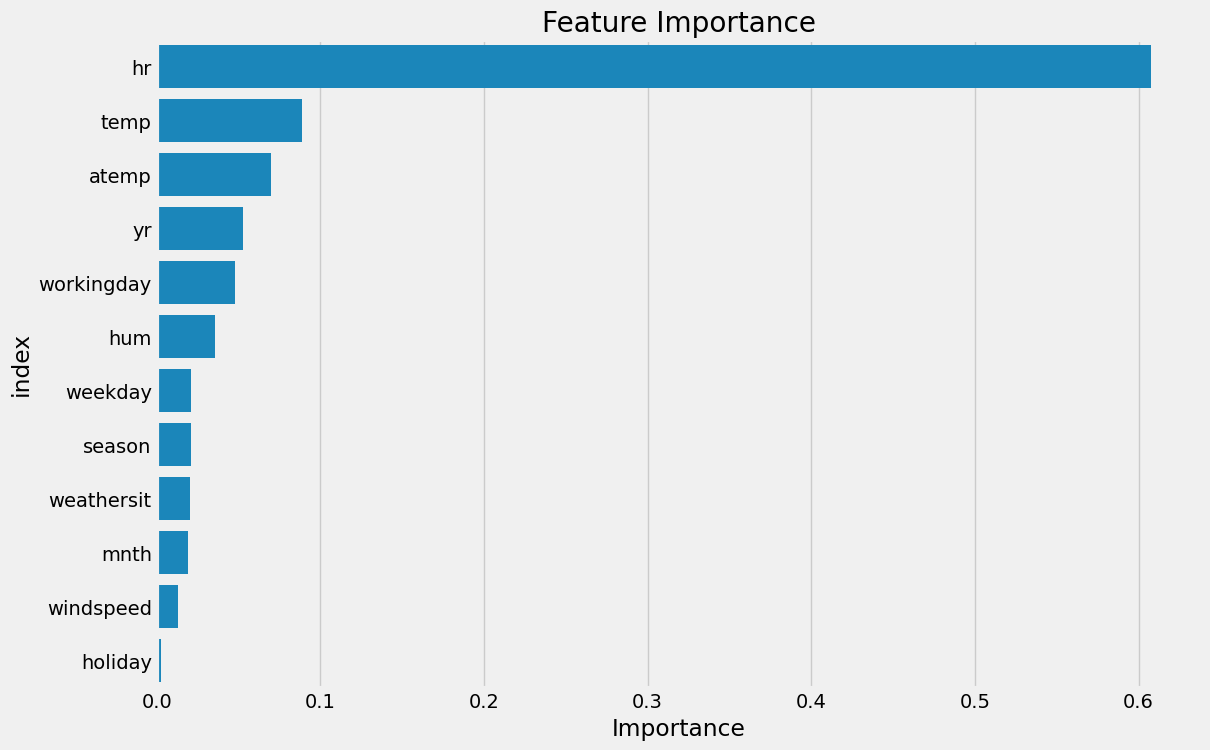

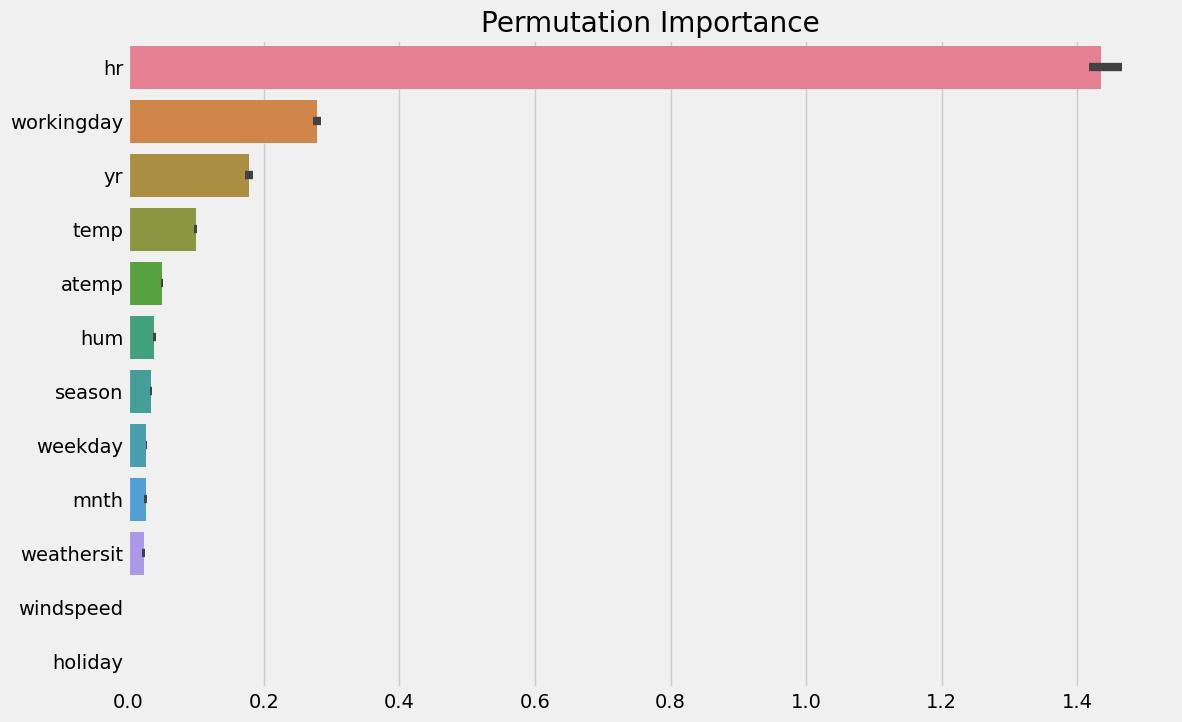

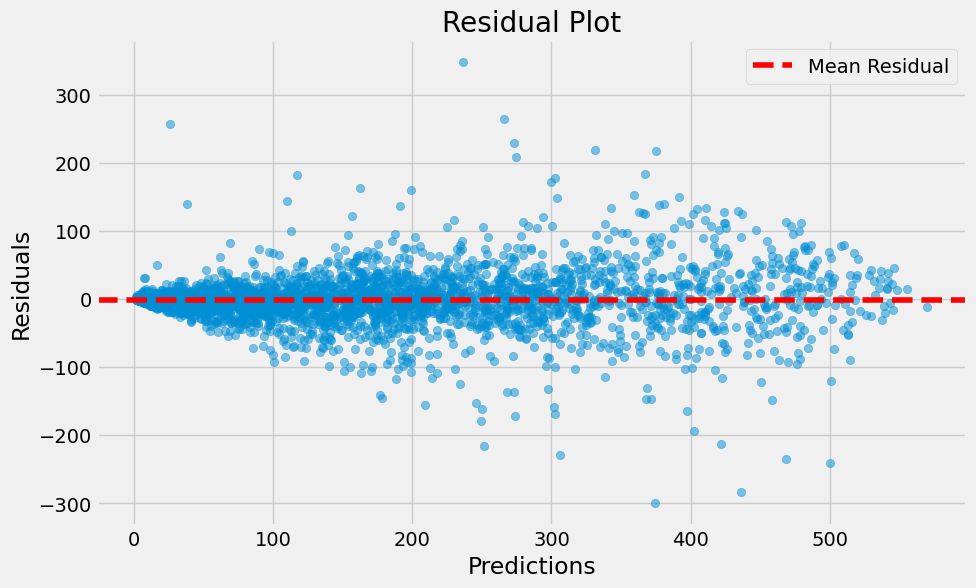

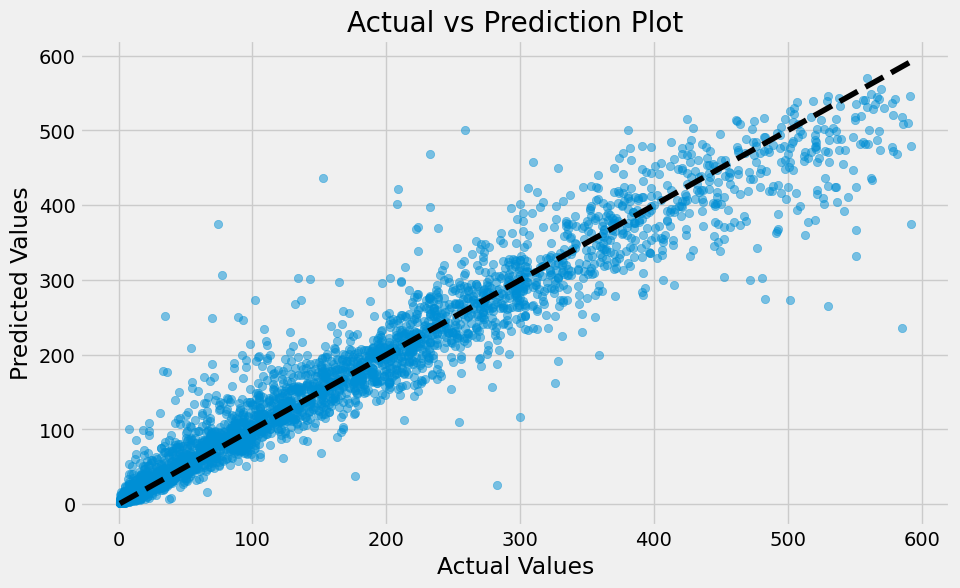

In [39]:
train_and_log_metrics(X_train, y_train, X_test, y_test)

## Fetching an MLflow Model from the Model Registry

### Fetch a specific model version

In [40]:
import mlflow.pyfunc

model_name = model_class.__class__.__name__
model_version = 1

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

y_pred = model.predict(X_test)
print(y_pred)

[304.55        96.59666667  22.82       ... 311.9        484.35333333
 206.06      ]


### Transitioning an MLflow Model’s Stage

In [41]:
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Staging"
)

<ModelVersion: aliases=[], creation_timestamp=1708488117258, current_stage='Staging', description=None, last_updated_timestamp=1708500345756, name='RandomForestRegressor', run_id='cc72317da537480bba88b36f9a3a53b8', run_link=None, source='/Users/fadhelfalah/Documents/kerjaan/learning/machine-learning-pipeline-mlflow/mlruns/138692355414413395/cc72317da537480bba88b36f9a3a53b8/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [42]:
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1708488117258, current_stage='Production', description=None, last_updated_timestamp=1708500346337, name='RandomForestRegressor', run_id='cc72317da537480bba88b36f9a3a53b8', run_link=None, source='/Users/fadhelfalah/Documents/kerjaan/learning/machine-learning-pipeline-mlflow/mlruns/138692355414413395/cc72317da537480bba88b36f9a3a53b8/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

# Best Model Results

In [43]:
mlflow.search_runs(order_by=['metrics.rmse ASC'], max_results=1)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mape,metrics.rmse,metrics.mae,params.n_estimators,params.max_features,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName
0,b9db897aea1046a5a2209cfa9600ee37,138692355414413395,FINISHED,/Users/fadhelfalah/Documents/kerjaan/learning/...,2024-02-20 18:28:03.345000+00:00,2024-02-20 18:34:05.439000+00:00,31.264373,38.972464,23.870922,300,10,"[{""run_id"": ""b9db897aea1046a5a2209cfa9600ee37""...",LOCAL,fadhelfalah,/Library/Frameworks/Python.framework/Versions/...,RandomForestRegressor - 21/02/2024 01:28:03


In [44]:
best_run_df = mlflow.search_runs(order_by=['metrics.rmse ASC'], max_results=1)
if len(best_run_df.index) == 0:
    raise Exception(f"Found no runs for experiment '{experiment_name}'")

best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
best_model = mlflow.sklearn.load_model(best_model_uri)

In [45]:
# print best run info
print("Best run info:")
print(f"Run id: {best_run.info.run_id}")
print(f"Run parameters: {best_run.data.params}")
print("Run score: RMSE_CV = {:.4f}".format(best_run.data.metrics['rmse']))
print(f"Run model URI: {best_model_uri}")

Best run info:
Run id: b9db897aea1046a5a2209cfa9600ee37
Run parameters: {'n_estimators': '300', 'max_features': '10'}
Run score: RMSE_CV = 38.9725
Run model URI: /Users/fadhelfalah/Documents/kerjaan/learning/machine-learning-pipeline-mlflow/mlruns/138692355414413395/b9db897aea1046a5a2209cfa9600ee37/artifacts/model


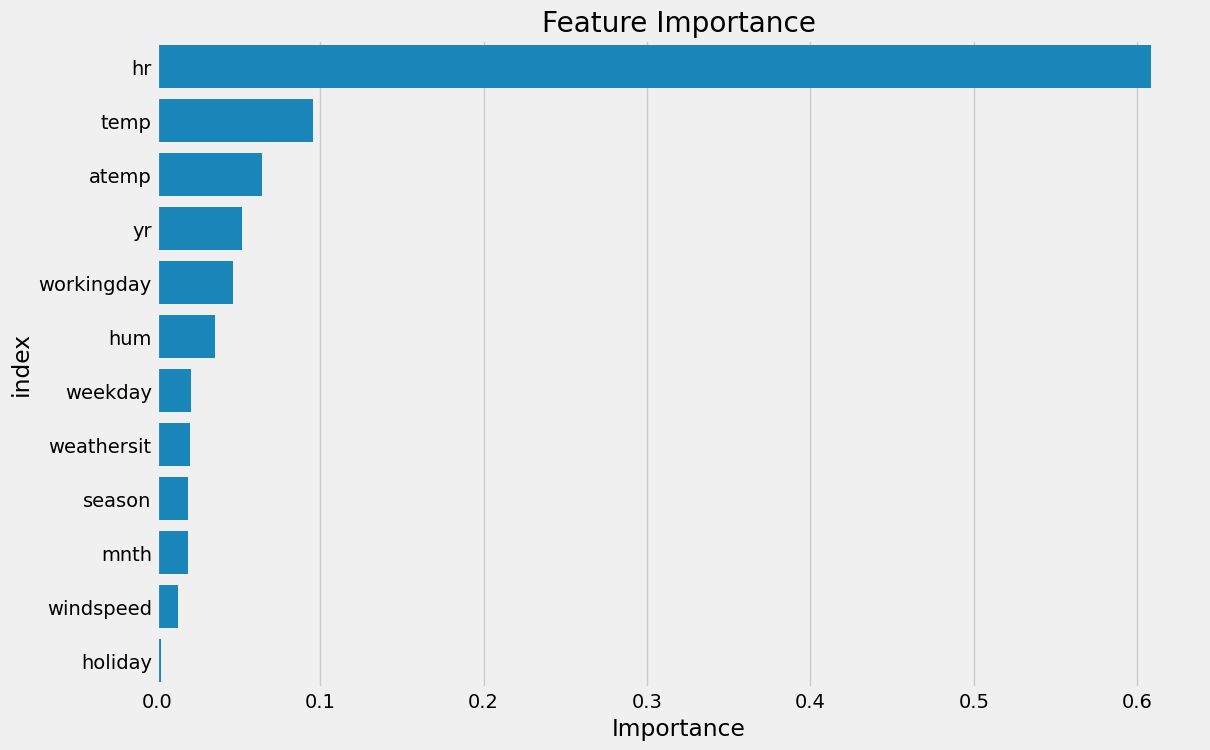

In [46]:
model_feature_importance(best_model)

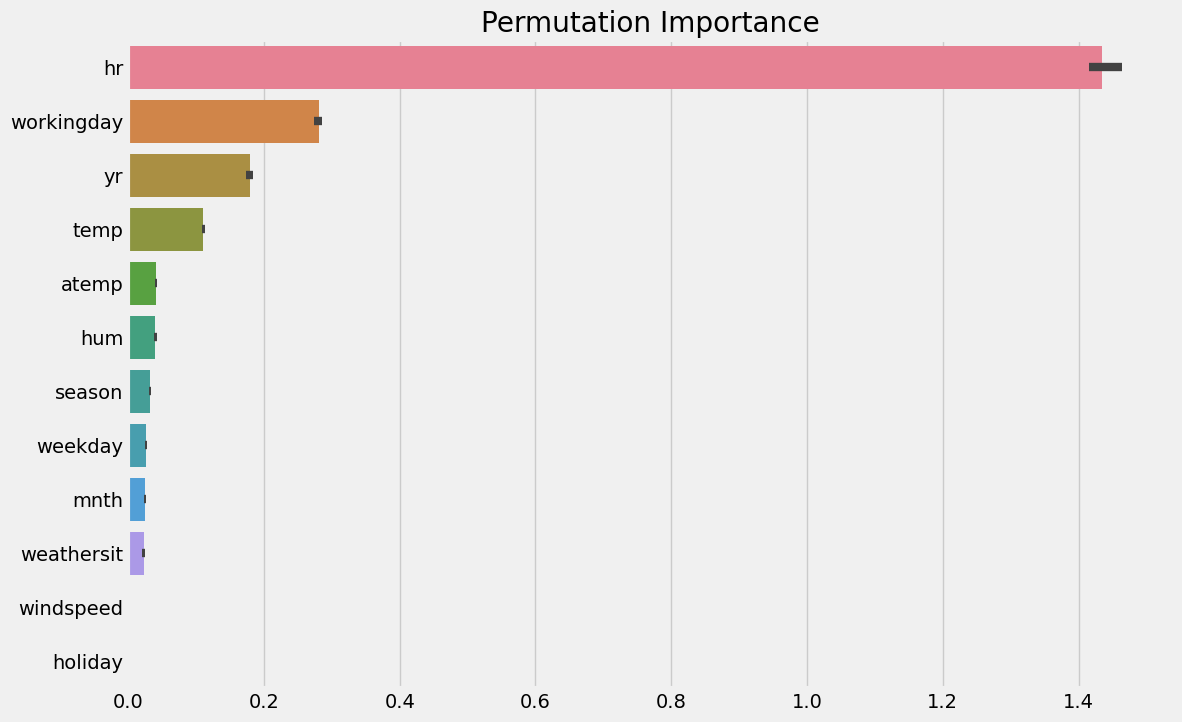

In [47]:
model_permutation_importance(best_model)

# Inference

In [48]:
test_predictions = X_test.copy()
# real output (cnt) from test dataset
test_predictions["cnt"] = y_test

# add "predicted_cnt" from test dataset
test_predictions["predicted_cnt"] = best_model.predict(X_test).astype(int)

# show results
test_predictions

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,predicted_cnt
16729,4,1,12,20,0,2,1,2,0.50,0.4848,0.63,0.2239,306,310
10891,2,1,4,23,0,2,1,1,0.50,0.4848,0.59,0.0000,79,99
485,1,0,1,7,0,6,0,1,0.02,0.0152,0.44,0.2836,8,21
14542,3,1,9,3,1,1,0,1,0.66,0.5909,0.89,0.1343,28,32
9655,1,1,2,6,0,0,0,1,0.10,0.0758,0.49,0.3881,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3734,2,0,6,12,0,4,1,1,0.92,0.8485,0.35,0.1940,140,142
3529,2,0,5,23,0,2,1,1,0.72,0.6970,0.79,0.0896,61,76
8259,4,0,12,19,0,4,1,2,0.52,0.5000,0.59,0.2836,287,308
16317,4,1,11,15,0,6,0,1,0.42,0.4242,0.35,0.2985,549,494


<Axes: title={'center': 'Rented bikes vs predicted rented bikes'}, xlabel='cnt', ylabel='predicted_cnt'>

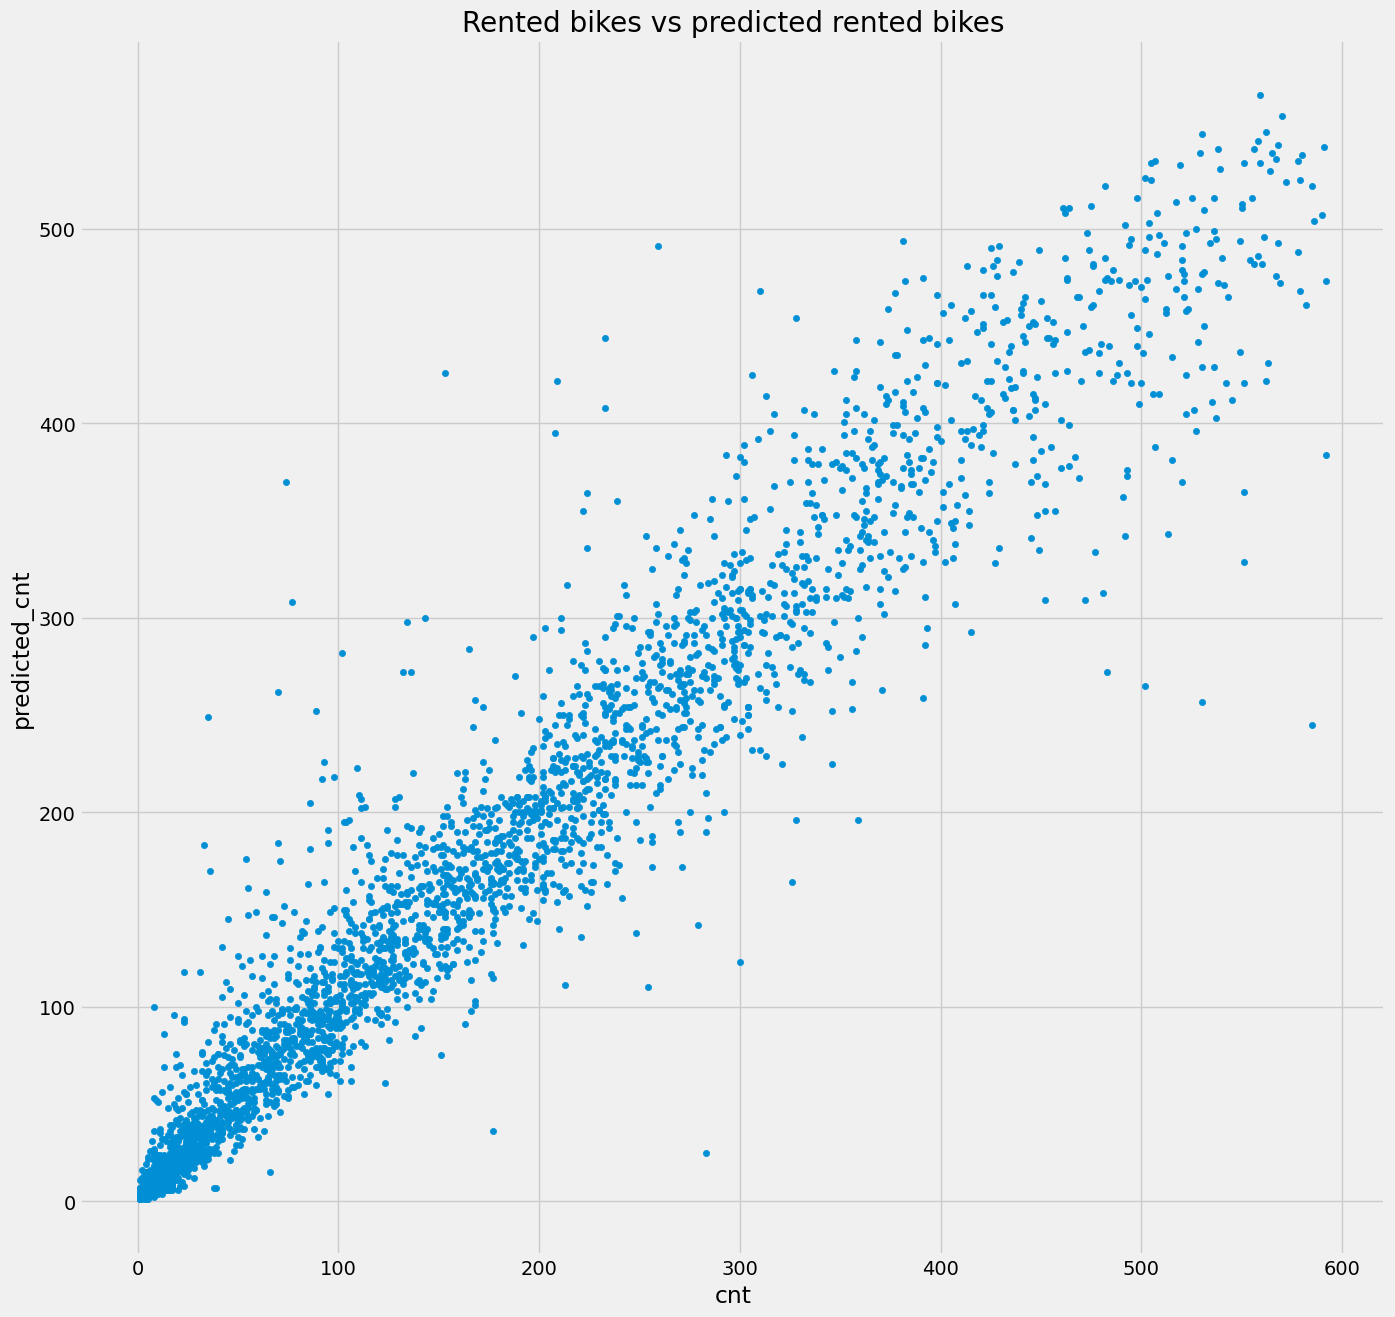

In [49]:
# plot truth vs prediction values
test_predictions.plot(
    kind="scatter",
    x="cnt",
    y="predicted_cnt",
    title="Rented bikes vs predicted rented bikes",
    figsize=(15, 15),
)

In [50]:
get_ipython().system_raw(f"mlflow models serve --model-uri {best_model_uri} --host 0.0.0.0 --port 3001 --workers 1 --no-conda &")
!sleep 5

2024/02/21 14:26:56 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/02/21 14:26:56 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 0.0.0.0:3001 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2024-02-21 14:26:56 +0700] [49192] [INFO] Starting gunicorn 21.2.0
[2024-02-21 14:26:56 +0700] [49192] [INFO] Listening at: http://0.0.0.0:3001 (49192)
[2024-02-21 14:26:56 +0700] [49192] [INFO] Using worker: sync
[2024-02-21 14:26:56 +0700] [49199] [INFO] Booting worker with pid: 49199


In [59]:
X_test.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

In [61]:
X_test.iloc[[0]].values.tolist()

[[4.0, 1.0, 12.0, 20.0, 0.0, 2.0, 1.0, 2.0, 0.5, 0.4848, 0.63, 0.2239]]

In [64]:
X_test_api = X_test.iloc[0:2].to_dict(orient='records')
X_test_api

[{'season': 4,
  'yr': 1,
  'mnth': 12,
  'hr': 20,
  'holiday': 0,
  'weekday': 2,
  'workingday': 1,
  'weathersit': 2,
  'temp': 0.5,
  'atemp': 0.4848,
  'hum': 0.63,
  'windspeed': 0.2239},
 {'season': 2,
  'yr': 1,
  'mnth': 4,
  'hr': 23,
  'holiday': 0,
  'weekday': 2,
  'workingday': 1,
  'weathersit': 1,
  'temp': 0.5,
  'atemp': 0.4848,
  'hum': 0.59,
  'windspeed': 0.0}]

In [69]:
%%bash
curl --silent --show-error --location 'http://localhost:3001/invocations' \
--header 'Content-Type: application/json' \
--data '{
    "inputs": {
        "season": 4.0,
        "yr": 1.0,
        "mnth": 12.0,
        "hr": 20.0,
        "holiday": 0.0,
        "weekday": 2.0,
        "workingday": 1.0,
        "weathersit": 2.0,
        "temp": 0.5,
        "atemp": 0.4848,
        "hum": 0.63,
        "windspeed": 0.2239
    }
}'



{"predictions": [310.0833333333333]}

[2024-02-21 15:44:03 +0700] [49192] [CRITICAL] WORKER TIMEOUT (pid:49199)
[2024-02-21 15:44:03 +0700] [49199] [INFO] Worker exiting (pid: 49199)
[2024-02-21 15:44:03 +0700] [49192] [ERROR] Worker (pid:49199) exited with code 1
[2024-02-21 15:44:03 +0700] [49192] [ERROR] Worker (pid:49199) exited with code 1.
[2024-02-21 15:44:03 +0700] [68680] [INFO] Booting worker with pid: 68680
[2024-02-21 16:01:14 +0700] [44445] [CRITICAL] WORKER TIMEOUT (pid:46562)
[2024-02-21 16:01:14 +0700] [44445] [CRITICAL] WORKER TIMEOUT (pid:46563)
[2024-02-21 16:01:14 +0700] [44445] [CRITICAL] WORKER TIMEOUT (pid:46564)
[2024-02-21 16:01:14 +0700] [44445] [CRITICAL] WORKER TIMEOUT (pid:46565)
[2024-02-21 16:01:14 +0700] [46564] [INFO] Worker exiting (pid: 46564)
[2024-02-21 16:01:14 +0700] [46563] [INFO] Worker exiting (pid: 46563)
[2024-02-21 16:01:14 +0700] [46562] [INFO] Worker exiting (pid: 46562)
[2024-02-21 16:01:14 +0700] [46565] [INFO] Worker exiting (pid: 46565)
[2024-02-21 16:01:14 +0700] [49192] 

In [68]:
%%bash
curl --silent --show-error --location 'http://localhost:3001/invocations' \
--header 'Content-Type: application/json' \
--data '{
    "inputs": [
      {
        "season": 4.0,
        "yr": 1.0,
        "mnth": 12.0,
        "hr": 20.0,
        "holiday": 0.0,
        "weekday": 2.0,
        "workingday": 1.0,
        "weathersit": 2.0,
        "temp": 0.5,
        "atemp": 0.4848,
        "hum": 0.63,
        "windspeed": 0.2239
    },
    {
        "season": 2.0,
        "yr": 1.0,
        "mnth": 4.0,
        "hr": 23.0,
        "holiday": 0.0,
        "weekday": 2.0,
        "workingday": 1.0,
        "weathersit": 1.0,
        "temp": 0.5,
        "atemp": 0.4848,
        "hum": 0.59,
        "windspeed": 0.0
    }
    ]
}'



{"predictions": [310.0833333333333, 99.04666666666667]}